In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [3]:
leaves = os.listdir('leaves/')
leaves

['1', '2', '3', '4', '5', '6', '7', '8']

In [4]:

image_paths = []
labels = []

for class_index, folder in enumerate(leaves, start=1):
    folder_path = os.path.join('leaves', folder)
    file_list = os.listdir(folder_path)
    
    for file_name in file_list:
        # Yalnızca resim uzantılı dosyaları işlemek isterseniz filtre koyabilirsiniz:
        ext = os.path.splitext(file_name)[1].lower()
        if ext not in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            continue
        
        full_path = os.path.join(folder_path, file_name)
        image_paths.append(full_path)
        labels.append(class_index)

# Python listelerini numpy array'e dönüştürelim (kolay işlenebilmesi için):
image_paths = np.array(image_paths)
labels = np.array(labels)

print("Toplam resim sayısı:", len(image_paths))
print("Örnek label:", labels[0])


Toplam resim sayısı: 3221
Örnek label: 1


In [5]:
from sklearn.model_selection import train_test_split

# 1) Tüm dataset -> train (%80) & test (%20)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,    # Her sınıftan dengeli örnek alınması için
    random_state=42
)

# 2) Train set -> train (%80) & validation (%20)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=0.25,     # 0.25 x 0.8 = 0.20 (toplamda %20 validation elde etmiş oluyoruz)
    stratify=train_labels,
    random_state=42
)

print("Train size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Test size:", len(test_paths))


Train size: 1932
Validation size: 644
Test size: 645


In [6]:
train_df = pd.DataFrame({
    'filepath': train_paths,
    'label': train_labels
})
val_df = pd.DataFrame({
    'filepath': val_paths,
    'label': val_labels
})
test_df = pd.DataFrame({
    'filepath': test_paths,
    'label': test_labels
})

train_df.head()


,filepath,label
0,leaves\4\image_2024-05-27_22-34-26_2.jpg,4
1,leaves\5\image_2024-05-29_13-16-45_4.jpg,5
2,leaves\5\image_2024-05-28_10-10-03_2.jpg,5
3,leaves\5\image_2024-06-03_09-24-37_0.jpg,5
4,leaves\6\image_2024-05-29_12-44-40_2.jpg,6


In [13]:
train_df['label'] = train_df['label'].astype(str)
val_df['label']   = val_df['label'].astype(str)
test_df['label']  = test_df['label'].astype(str)


In [14]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
img_height = 224
img_width = 224

# Flow from DataFrame (çoklu sınıf için class_mode='categorical' diyelim)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1938 validated image filenames belonging to 8 classes.
Found 646 validated image filenames belonging to 8 classes.
Found 646 validated image filenames belonging to 8 classes.


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))  # 8 sınıf

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Çoklu sınıf
    metrics=['accuracy']
)

model.summary()


e:\Kodlar\OGÜ\PatternRecognation\pattern_rec\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,888 (42.61 MB)

 Trainable params: 11,170,440 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs
)


e:\Kodlar\OGÜ\PatternRecognation\pattern_rec\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.7374 - loss: 1.1790 - val_accuracy: 0.3498 - val_loss: 2.7169
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 53s 864ms/step - accuracy: 0.9527 - loss: 0.1968 - val_accuracy: 0.1269 - val_loss: 4.8437
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 53s 865ms/step - accuracy: 0.9563 - loss: 0.2236 - val_accuracy: 0.1269 - val_loss: 6.7233
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 53s 865ms/step - accuracy: 0.9627 - loss: 0.1495 - val_accuracy: 0.1269 - val_loss: 9.7363
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 53s 860ms/step - accuracy: 0.9687 - loss: 0.1556 - val_accuracy: 0.1269 - val_loss: 11.7570
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 56s 912ms/step - accuracy: 0.9681 - loss: 0.1384 - val_accuracy: 0.1316 - val_loss: 6.2236
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 58s 946ms/step - accuracy: 0.9675 - loss: 0.1459 - val_accuracy: 0.5728 - val_loss: 1.8028
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 56s 914ms/step - accuracy: 0.9675 - loss: 0.1691 - val_accura

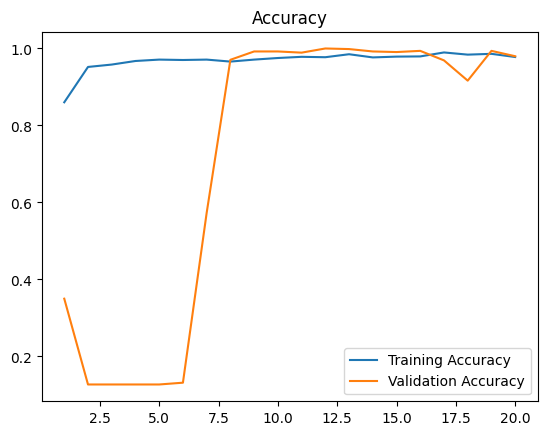

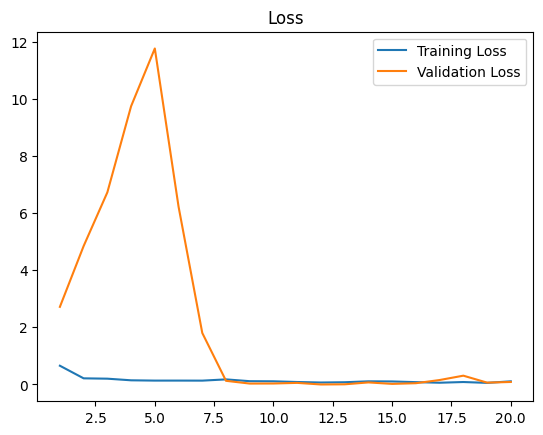

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs+1)

plt.figure()
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.figure()
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [21]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - accuracy: 0.9842 - loss: 0.1040
Test Loss: 0.0991
Test Accuracy: 0.9845


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Modelden tahminler
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = tf.argmax(predictions, axis=1).numpy()

true_classes = test_generator.classes  # flow_from_dataframe ile .classes int etiketleri döndürür
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00       128
           5       1.00      0.94      0.97       145
           6       1.00      0.99      1.00       101
           7       1.00      1.00      1.00         7
           8       0.81      1.00      0.90        43

    accuracy                           0.98       646
   macro avg       0.98      0.99      0.98       646
weighted avg       0.99      0.98      0.99       646

Confusion Matrix:
[[119   0   0   0   0   0   0   0]
 [  0  81   0   0   0   0   0   0]
 [  0   0  22   0   0   0   0   0]
 [  0   0   0 128   0   0   0   0]
 [  0   0   0   0 136   0   0   9]
 [  0   0   0   0   0 100   0   1]
 [  0   0   0   0   0   0   7   0]
 [  0   0   0   0   0 